# House_Prices_Advanced_Regression_Techniques usando XGBoost

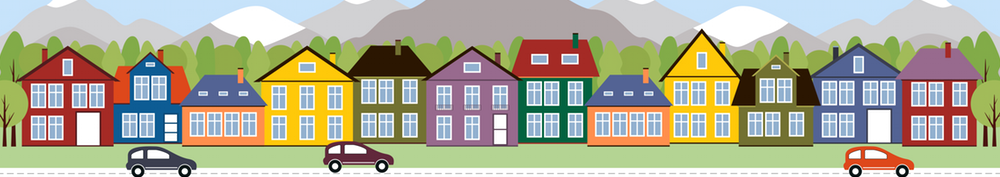

Link do Desafio: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

In [1]:
# Importando o pandas
import pandas as pd

data_description = "https://raw.githubusercontent.com/LucasRodriguesDeFreitas/House-Prices/main/data_description.txt"
sample_submission = "https://raw.githubusercontent.com/LucasRodriguesDeFreitas/House-Prices/main/sample_submission.csv"
base_teste = "https://raw.githubusercontent.com/LucasRodriguesDeFreitas/House-Prices/main/test.csv"
base_train = "https://raw.githubusercontent.com/LucasRodriguesDeFreitas/House-Prices/main/train.csv"

In [2]:
# Importando o dataset de treino
base = pd.read_csv(base_train)

In [3]:
# Visualizando essa base
base.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
# Retornando o shape da base
base.shape

(1460, 81)

In [5]:
# E as informações
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Exploratoria de Dados

In [6]:
# Visualizando quantidade de valores vazios

# Valores Nulos
# base.isnull()

# Linhas nulas por Coluna
# base.isnull().sum().sort_values(ascending=False)

# Porcentagem de valores nulos por coluna
(base.isnull().sum()/base.shape[0]).sort_values(ascending=False)

,0
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
MasVnrType,0.597260
...,...
MoSold,0.000000
YrSold,0.000000
SaleType,0.000000
SaleCondition,0.000000


In [7]:
# Podemos eliminar as colunas com mais de 10% de valores vazios

eliminar = base.columns[(base.isnull().sum()/base.shape[0]) > 0.1]
eliminar

Index(['LotFrontage', 'Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [8]:
# Eliminando essas colunas
base_new = base.drop(eliminar, axis=1)

In [9]:
# Visualizando quantidade de valores vazios

(base_new.isnull().sum()/base_new.shape[0]).sort_values(ascending=False)

,0
GarageYrBlt,0.055479
GarageQual,0.055479
GarageCond,0.055479
GarageType,0.055479
GarageFinish,0.055479
...,...
MoSold,0.000000
YrSold,0.000000
SaleType,0.000000
SaleCondition,0.000000


In [10]:
# Verificando se existe valroes duplicados
base_new.duplicated().sum()

np.int64(0)

In [11]:
# Verificando as colunas categoricas
categorical_cols = base_new.select_dtypes(include=["object"]).columns
print(categorical_cols)

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [12]:
# Criando categorias com as colunas Object
for col in categorical_cols:
    base_new[col] = base_new[col].astype('category')


base_new.dtypes

,0
Id,int64
MSSubClass,int64
MSZoning,category
LotArea,int64
Street,category
...,...
MoSold,int64
YrSold,int64
SaleType,category
SaleCondition,category


In [13]:
# Selecionando apenas as colunas numéricas
colunas = base_new.columns[base_new.dtypes != 'object']
colunas

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch'

In [14]:
# Criando uma nova base com esses valores

base_tratada = base_new.loc[:,colunas]
base_tratada.head(3)

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500


In [15]:
# Verificando os valores vazios

base_tratada.isnull().sum().sort_values(ascending=False)

,0
GarageYrBlt,81
GarageQual,81
GarageCond,81
GarageType,81
GarageFinish,81
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


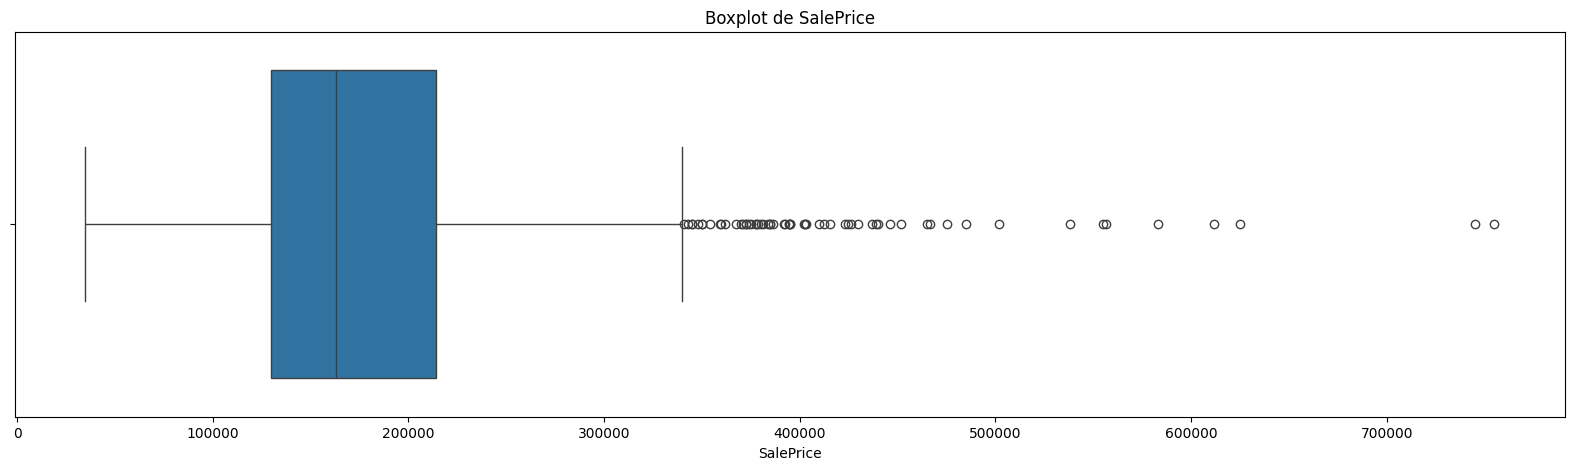

In [16]:
# Identificando Outliers na coluna SalePrice

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
sns.boxplot(x = base_tratada['SalePrice'])
plt.title('Boxplot de SalePrice')
plt.show()

In [17]:
# Tamanho da base antes de remover os Outliers
print('Base numerica antes de remover os Outliers: ', base_tratada.shape[0])

Base numerica antes de remover os Outliers:  1460


In [18]:
# Removendo Outliers com IsolationForest

from sklearn.ensemble import IsolationForest

#Treinar o modelo

iso_forest = IsolationForest(random_state=42, contamination=0.05)
base_tratada['Outlier'] = iso_forest.fit_predict(base_tratada[['SalePrice']])
base_tratada = base_tratada[base_tratada['Outlier'] != -1]

print('Base numerica após remover os Outliers: ', base_tratada.shape[0])

Base numerica após remover os Outliers:  1387


# Preparando os dados para o Modelo de XGBoost

In [19]:
# Selecionando X e y

X = base_tratada.drop('SalePrice', axis=1)
y = base_tratada['SalePrice']

In [20]:
# Importando o train_test_split

from sklearn.model_selection import train_test_split

In [21]:
# Separando essa base em treino e teste

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42)

In [22]:
# Normalizando os Dados
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

scaler = MinMaxScaler()

numerical_features = X_train.select_dtypes(include=['number']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features) #sparse=False for numpy array output
    ])

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=preprocessor.get_feature_names_out(X_train.columns))
X_test_scaled = pd.DataFrame(X_test_scaled, columns=preprocessor.get_feature_names_out(X_train.columns))

In [23]:
# Aplicando Tranformação Logarítmica
import numpy as np

# Criando o y_train_log
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Criando Funções para validação do modelo

In [24]:
# Plotar grafico da curva de aprendizagem
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes= np.linspace(0.1, 1.0, 5),
        cv=3,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    plt.figure(figsize=(8, 4))
    plt.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', label='Treino')
    plt.plot(train_sizes, -np.mean(val_scores, axis=1), 'o-', label='Validação')
    plt.title('Curva de Aprendizagem (Simplificada)')
    plt.xlabel('Tamanho do Conjunto de Treino')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

# Modelo XGBoost com Trasformação logaritmica

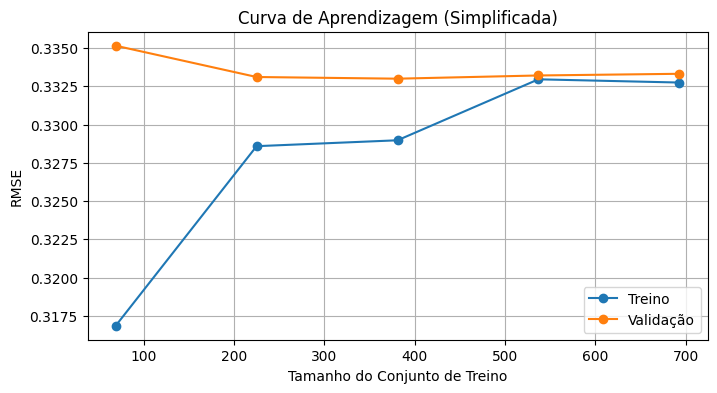

In [67]:
# Importando o XGBoost
from xgboost import XGBRegressor

#Criando o regressor e fazendo o fit com os dados de treino
reg_xgb_log = XGBRegressor(objective = 'reg:squarederror',
                           enable_categorical=True,
                           n_estimators = 500,
                           learning_rate = 0.000005,
                           max_depth = 8,
                           subsample = 0.8,
                           reg_alpha = 0.1,
                           random_state = 42).fit(X_train_scaled, y_train_log)

# Plotando curva de aprendizado
plot_learning_curve(reg_xgb_log, X_train, y_train_log)

In [68]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Previsões no conjunto de treino e teste
y_train_pred = reg_xgb_log.predict(X_train_scaled)
y_test_pred = reg_xgb_log.predict(X_test_scaled)

# Calculando o R² (coeficiente de determinação) para treino e teste
r2_train = r2_score(y_train_log, y_train_pred)
r2_test = r2_score(y_test_log, y_test_pred)

# Calculando o RMSE para treino e teste
rmse_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test_log, y_test_pred))

print(f'R² - Treinamento: {r2_train:.4f}')
print(f'R² - Teste: {r2_test:.4f}')
print(f'RMSE - Treinamento: {rmse_train:.4f}')
print(f'RMSE - Teste: {rmse_test:.4f}')


R² - Treinamento: 0.0042
R² - Teste: 0.0034
RMSE - Treinamento: 0.3329
RMSE - Teste: 0.3382


In [27]:
from sklearn.model_selection import cross_val_score

# Realizando validação cruzada (K-folds)
scores = cross_val_score(reg_xgb_log, X_train_scaled, y_train_log, cv=5, scoring='neg_mean_squared_error')

# Calculando a média e o desvio padrão dos scores
print(f'Média do RMSE (validação cruzada): {np.mean(np.sqrt(-scores)):.4f}')
print(f'Desvio padrão do RMSE (validação cruzada): {np.std(np.sqrt(-scores)):.4f}')


Média do RMSE (validação cruzada): 0.1260
Desvio padrão do RMSE (validação cruzada): 0.0071


In [28]:
y_pred_xgb_log = reg_xgb_log.predict(X_test_scaled)

# Avaliando Modelos

In [29]:
# Erro quadrático médio
from sklearn.metrics import mean_squared_error

# Avaliando o erro da XGB com Log
print(f'XGBRegressor com Log: {mean_squared_error(y_test, y_pred_xgb_log)}')

XGBRegressor com Log: 33978404864.0


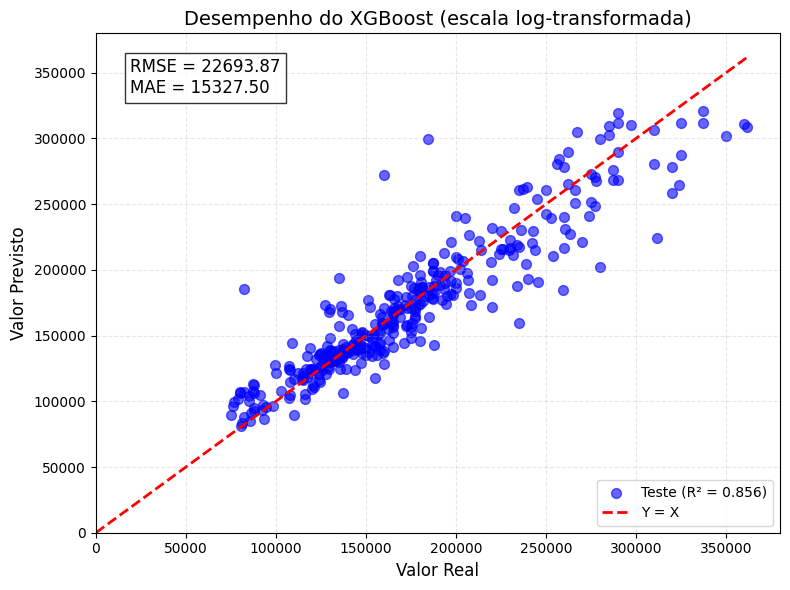

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Calculando métricas para o modelo XGB_log (convertendo de volta da escala log)
y_test_orig = np.exp(y_test_log)
y_pred_orig = np.exp(y_pred_xgb_log)

r2 = r2_score(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae = mean_absolute_error(y_test_orig, y_pred_orig)

# Criando o gráfico
plt.figure(figsize=(8, 6))
sc = plt.scatter(y_test_orig, y_pred_orig,
                c='blue', alpha=0.6, s=50,
                label=f'Teste (R² = {r2:.3f})')

# Linha de referência
max_val = max(y_test_orig.max(), y_pred_orig.max())
plt.plot([0, max_val], [0, max_val], '--r', linewidth=2, label="Y = X")

# Adicionando métricas como texto
textstr = '\n'.join((
    f'RMSE = {rmse:.2f}',
    f'MAE = {mae:.2f}'))
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

# Configurações do gráfico
plt.title('Desempenho do XGBoost (escala log-transformada)', fontsize=14)
plt.xlabel('Valor Real', fontsize=12)
plt.ylabel('Valor Previsto', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.3)

# Ajustando limites
plt.xlim(0, max_val * 1.05)
plt.ylim(0, max_val * 1.05)

plt.tight_layout()
plt.show()


# Base de Teste do Kaggle



In [31]:
# Importando a base de teste

base_teste = pd.read_csv(base_teste)

In [33]:
# Para guardar na hora da submission
base_teste2 = base_teste.copy()

In [34]:
# Visualizando a base

base_teste.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [35]:
# Tamanho da base de teste

print('Tamanho da base de teste: ',base_teste.shape[0])

Tamanho da base de teste:  1459


In [36]:
# Visualizando quantidade de valores vazios

# Valores Nulos
#base_teste.isnull()

# Linhas nulas por Coluna
#base.isnull().sum().sort_values(ascending=False)

# Porcentagem de valores nulos por coluna
(base_teste.isnull().sum()/base.shape[0]).sort_values(ascending=False)

,0
PoolQC,0.997260
MiscFeature,0.964384
Alley,0.926027
Fence,0.800685
MasVnrType,0.612329
...,...
EnclosedPorch,0.000000
MiscVal,0.000000
MoSold,0.000000
YrSold,0.000000


In [37]:
# Verificando as colunas categoricas
categorical_cols = base_teste.select_dtypes(include=["object"]).columns
print(categorical_cols)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [38]:
# Criando categorias com as colunas Object
for col in categorical_cols:
    base_teste[col] = base_teste[col].astype('category')


base_teste.dtypes

,0
Id,int64
MSSubClass,int64
MSZoning,category
LotFrontage,float64
LotArea,int64
...,...
MiscVal,int64
MoSold,int64
YrSold,int64
SaleType,category


In [39]:
# Selecionando apenas as colunas numéricas
colunas = base_teste.columns[base_teste.dtypes != 'object']
colunas

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [40]:
# Criando uma nova base com esses valores
base_teste = base_teste.loc[:,colunas]
base_teste.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [41]:
# Verificando os valores vazios

base_teste.isnull().sum().sort_values(ascending=False)

,0
PoolQC,1456
MiscFeature,1408
Alley,1352
Fence,1169
MasVnrType,894
...,...
EnclosedPorch,0
MiscVal,0
MoSold,0
YrSold,0


In [42]:
base_teste.shape

(1459, 80)

# Aplicando o Modelo na base do Kaggle

In [69]:
# Fazendo a previsão
training_features = reg_xgb_log.get_booster().feature_names

# Ensure base_teste has all the required columns with the same names
# If a column is missing, it will be added with NaN values
for feature in training_features:
    if feature not in base_teste.columns:
        base_teste[feature] = np.nan  # Fill with NaN or appropriate value

# Now you can safely select all training features
base_teste = base_teste[training_features]

y_pred_xgb = reg_xgb_log.predict(base_teste)

In [70]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Previsões no conjunto de treino e teste
y_train_pred = reg_xgb_log.predict(X_train_scaled)
y_test_pred = reg_xgb_log.predict(X_test_scaled)

# Calculando o R² (coeficiente de determinação) para treino e teste
r2_train = r2_score(y_train_log, y_train_pred)
r2_test = r2_score(y_test_log, y_test_pred)

# Calculando o RMSE para treino e teste
rmse_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test_log, y_test_pred))

print(f'R² - Treinamento: {r2_train:.4f}')
print(f'R² - Teste: {r2_test:.4f}')
print(f'RMSE - Treinamento: {rmse_train:.4f}')
print(f'RMSE - Teste: {rmse_test:.4f}')


R² - Treinamento: 0.0042
R² - Teste: 0.0034
RMSE - Treinamento: 0.3329
RMSE - Teste: 0.3382


# Submission para o Kaggle

In [71]:
print("Shape do treino:", X_train.shape)
print("Shape do teste:", base_teste.shape)
print("Shape das previsões:", y_pred_xgb.shape)

Shape do treino: (1040, 74)
Shape do teste: (1459, 37)
Shape das previsões: (1459,)


In [77]:
print(base_teste.columns)
print(y_pred_xgb)

Index(['num__Id', 'num__MSSubClass', 'num__LotArea', 'num__OverallQual',
       'num__OverallCond', 'num__YearBuilt', 'num__YearRemodAdd',
       'num__MasVnrArea', 'num__BsmtFinSF1', 'num__BsmtFinSF2',
       'num__BsmtUnfSF', 'num__TotalBsmtSF', 'num__1stFlrSF', 'num__2ndFlrSF',
       'num__LowQualFinSF', 'num__GrLivArea', 'num__BsmtFullBath',
       'num__BsmtHalfBath', 'num__FullBath', 'num__HalfBath',
       'num__BedroomAbvGr', 'num__KitchenAbvGr', 'num__TotRmsAbvGrd',
       'num__Fireplaces', 'num__GarageYrBlt', 'num__GarageCars',
       'num__GarageArea', 'num__WoodDeckSF', 'num__OpenPorchSF',
       'num__EnclosedPorch', 'num__3SsnPorch', 'num__ScreenPorch',
       'num__PoolArea', 'num__MiscVal', 'num__MoSold', 'num__YrSold',
       'num__Outlier'],
      dtype='object')
[12.005864 12.005864 12.005864 ... 12.005864 12.005864 12.005864]


In [72]:
# Fazendo a previsão
training_features = reg_xgb_log.get_booster().feature_names

# Cria uma cópia de base_teste para evitar modificar o DataFrame original
base_teste_selected = base_teste.copy()

# Garantir que base_teste_selected tenha todas as colunas necessárias com os mesmos nomes
# Se uma coluna estiver faltando, ela será adicionada com valores NaN
for feature in training_features:
    if feature not in base_teste_selected.columns:
        base_teste_selected[feature] = np.nan

base_teste_selected = base_teste_selected[training_features]

y_pred_xgb = reg_xgb_log.predict(base_teste_selected)


In [74]:
# Criando um submission do XGBoost

submission = pd.DataFrame()

# Verifica se a coluna 'Id' existe antes de acessá-la
if 'Id' in base_teste.columns:
    submission['Id'] = base_teste['Id']  # Acessa 'Id' se existir
else:
    # Trata o caso em que 'Id' está ausente
    # Por exemplo, pode atribuir um valor padrão ou gerar um erro
    # Aqui, estou atribuindo uma sequência de valores como exemplo
    submission['Id'] = range(1461, 1461 + len(base_teste))
    print("Aviso: Coluna 'Id' não encontrada em base_teste. Usando valores padrão.")

submission['SalePrice'] = np.expm1(y_pred_xgb)

submission.to_csv('submission_xgb.csv', index=False)


Aviso: Coluna 'Id' não encontrada em base_teste. Usando valores padrão.


V1_Submission Score: 0.63364

V2_Submission Score: 0.41609